In [4]:
import numpy as np
import matplotlib.pyplot as plt
import nengo
import ssp_bayes_opt
from scipy.special import softmax

A normal SSP:

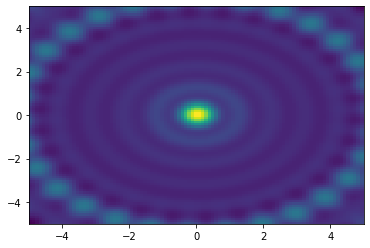

In [2]:
n_scales=6
n_rotates=5
bounds = 5*np.array([[-1,1],[-1,1]])
ssp_space = ssp_bayes_opt.sspspace.HexagonalSSPSpace(2,
                                    ssp_dim=151, 
                                    n_rotates=5, 
                                    n_scales=n_scales, 
                                    scale_min=0.05,
                                    scale_max=3,
                                    domain_bounds=bounds, 
                                    length_scale=0.5,
                                      )
S0 = ssp_space.encode(np.array([[0,0]]))  
ssp_space.similarity_plot(S0)

SSPs representing two regions:

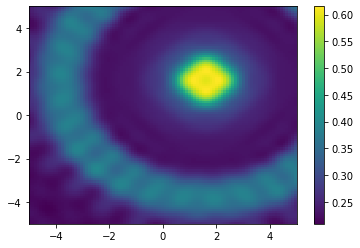

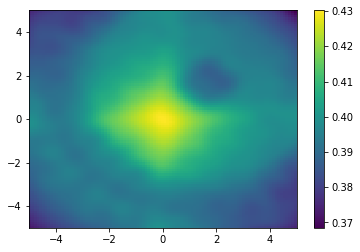

In [3]:
xs = np.linspace(bounds[0,0],bounds[0,1],20)
ys = np.linspace(bounds[1,0],bounds[1,1],20)
X,Y = np.meshgrid(xs,ys)
xy = np.vstack([X.reshape(-1),Y.reshape(-1)]).T


dists = np.sqrt(np.sum((xy - np.array([1.5,1.5]))**2, axis=1))
r1_pts = xy[dists>1,:]
r2_pts = xy[dists<=1,:]
S_r1 = ssp_space.normalize(np.sum(ssp_space.encode(r1_pts),axis=0))
S_r2 = ssp_space.normalize(np.sum(ssp_space.encode(r2_pts),axis=0))
S_regions = np.vstack([S_r1,S_r2])


im=ssp_space.similarity_plot(S_r2)
plt.colorbar(im)
im=ssp_space.similarity_plot(S_r1)
plt.colorbar(im)


Using masks in the fourier domain to change the length scale:

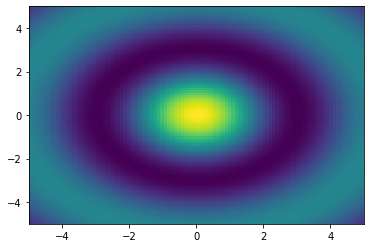

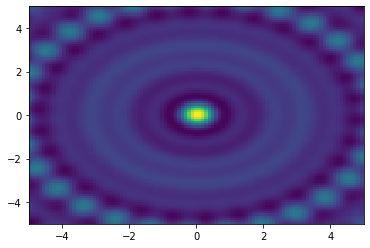

In [4]:
break_idx=4
scale_mask = np.ones((n_scales,2))
scale_mask[:break_idx,0] = 0
scale_mask[break_idx:,1] = 0

mask_half = np.tile(np.repeat(scale_mask,3,axis=0),(n_rotates,1))
masks = np.vstack([[1,1],mask_half, np.flip(mask_half,axis=0)]).T


ssp_space.similarity_plot( np.fft.ifft(np.fft.fft(S0)*masks[0,:]).real )
ssp_space.similarity_plot( np.fft.ifft(np.fft.fft(S0)*masks[1,:]).real )

Encoding an SSP in such a way that the length scale changes depending on its membership in different regions:

In [5]:
ssp=ssp_space.encode(np.array([[1,1]]))  
S_regions @ ssp.T

array([[0.40356575],
       [0.50898883]])

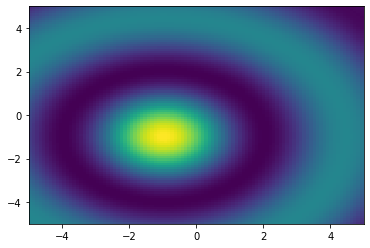

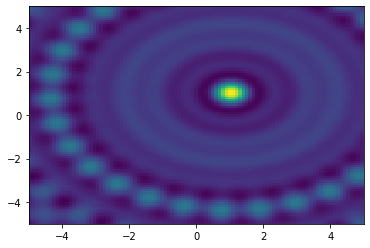

In [6]:
def region_mask_ssp(ssp):
    fssp = np.fft.fft(ssp,axis=1)
    # weights = softmax(S_regions @ ssp.T)
    probs = S_regions @ ssp.T #softmax
    maxprobs = np.argmax(probs,axis=0)
    weights = np.zeros((S_regions.shape[0],ssp.shape[0])) 
    weights[(maxprobs,np.arange(ssp.shape[0]))] = 1
    weighted_masks =  weights.T @ masks
    #np.sum(weights * masks, axis=0)
    return np.fft.ifft(weighted_masks*fssp,axis=1).real

S_ex = ssp_space.encode(np.array([[-1,-1]]))  
ssp_space.similarity_plot(region_mask_ssp(S_ex))

S_ex = ssp_space.encode(np.array([[1,1]]))  
ssp_space.similarity_plot(region_mask_ssp(S_ex))

Above we have the similarity of the modified SSP with normal SSPs gridded across space. 

Instead, all SSPs (including in grid) can be modifed:

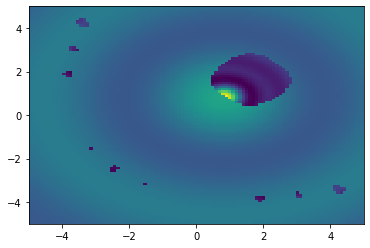

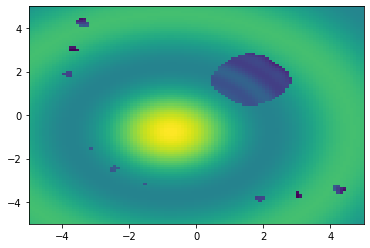

In [7]:
def similarity_plot_v2(ssp_space,ssp,n_grid=100,plot_type='heatmap',ax=None,**kwargs):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    xs = np.linspace(ssp_space.domain_bounds[0,0],ssp_space.domain_bounds[0,1], n_grid)
    ys = np.linspace(ssp_space.domain_bounds[1,0],ssp_space.domain_bounds[1,1], n_grid)
    X,Y = np.meshgrid(xs,ys)
    sims = ssp @ region_mask_ssp(ssp_space.encode(np.vstack([X.reshape(-1),Y.reshape(-1)]).T)).T
    if plot_type=='heatmap':
        im = ax.pcolormesh(X,Y,sims.reshape(X.shape),**kwargs)
    elif plot_type=='contour':
        im = ax.contour(X,Y,sims.reshape(X.shape),**kwargs)
    elif plot_type=='contourf':
        im = ax.contourf(X,Y,sims.reshape(X.shape),**kwargs)
    ax.set_xlim(ssp_space.domain_bounds[0,0],ssp_space.domain_bounds[0,1])
    ax.set_ylim(ssp_space.domain_bounds[1,0],ssp_space.domain_bounds[1,1])
    return im

S_ex = ssp_space.encode(np.array([[0.8,0.8]]))  
similarity_plot_v2(ssp_space,S_ex)

S_ex = ssp_space.encode(np.array([[-0.8,-0.8]]))  
similarity_plot_v2(ssp_space,S_ex)

540.0


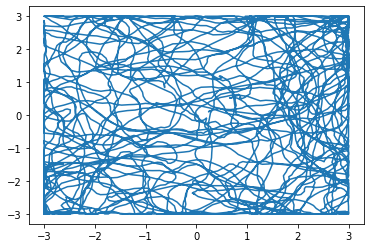

In [10]:

onlinedata = np.load('multiple_sources_data_array.npy',allow_pickle=True)
path = onlinedata[2][:,:2] 
shift_fun = lambda x, new_min, new_max: (new_max - new_min)*(x - np.min(x))/(np.max(x) - np.min(x))  + new_min
path[:,0] = shift_fun(path[:,0], -3,3)
path[:,1] = shift_fun(path[:,1], -3,3)

dt = 0.1
timesteps = np.arange(0,dt*path.shape[0] + dt,dt)
T = timesteps[-1]

plt.figure()
plt.plot(path[:,0],path[:,1])
print(T)

In [9]:
def sample_grid_encoders(ssp_space, n):
    sample_pts = ssp_space.get_sample_points(n,method='sobol')
    n = sample_pts.shape[0]
    N = ssp_space.num_grids
    if N < n:
        sorts = np.hstack([np.arange(N), np.random.randint(0, N - 1, size = n - N)])
    else:
        sorts = np.arange(n)
    encoders = np.zeros((n,ssp_space.ssp_dim))
    for i in range(n):
        sub_mat = _get_sub_SSP(sorts[i],N,sublen=ssp_space.grid_basis_dim)
        #print(sub_mat.shape)
        proj_mat = _proj_sub_SSP(sorts[i],N,sublen=ssp_space.grid_basis_dim)
        sub_space = ssp_bayes_opt.sspspace.SSPSpace(ssp_space.domain_dim,2*ssp_space.grid_basis_dim + 1, 
                             axis_matrix= sub_mat @ ssp_space.axis_matrix)
        encoders[i,:] = N * proj_mat @ sub_space.encode(np.atleast_2d(sample_pts[i,:])).reshape(-1)
    return encoders, sorts

def _get_sub_FourierSSP(n, N, sublen=3):
    # Return a matrix, \bar{A}_n
    # Consider the multi scale representation (S_{total}) and sub vectors (S_n) described in the paper 
    # Then
    # \bar{A}_n F{S_{total}} = F{S_n}
    # i.e. pick out the sub vector in the Fourier domain
    tot_len = 2*sublen*N + 1
    FA = np.zeros((2*sublen + 1, tot_len))
    FA[0:sublen, sublen*n:sublen*(n+1)] = np.eye(sublen)
    FA[sublen, sublen*N] = 1
    FA[sublen+1:, tot_len - np.arange(sublen*(n+1),sublen*n,-1)] = np.eye(sublen)
    return FA

def _get_sub_SSP(n,N,sublen=3):
    # Return a matrix, A_n
    # Consider the multi scale representation (S_{total}) and sub vectors (S_n) described in the paper 
    # Then
    # A_n S_{total} = S_n
    # i.e. pick out the sub vector in the time domain
    tot_len = 2*sublen*N + 1
    FA = _get_sub_FourierSSP(n,N,sublen=sublen)
    W = np.fft.fft(np.eye(tot_len))
    invW = np.fft.ifft(np.eye(2*sublen + 1))
    A = invW @ np.fft.ifftshift(FA) @ W
    return A.real

def _proj_sub_FourierSSP(n,N,sublen=3):
    # Return a matrix, \bar{B}_n
    # Consider the multi scale representation (S_{total}) and sub vectors (S_n) described in the paper 
    # Then
    # \sum_n \bar{B}_n F{S_{n}} = F{S_{total}}
    # i.e. project the sub vector in the Fourier domain such that summing all such projections gives the full vector in Fourier domain
    tot_len = 2*sublen*N + 1
    FB = np.zeros((2*sublen + 1, tot_len))
    FB[0:sublen, sublen*n:sublen*(n+1)] = np.eye(sublen)
    FB[sublen, sublen*N] = 1/N # all sub vectors have a "1" zero freq term so scale it so full vector will have 1 
    FB[sublen+1:, tot_len - np.arange(sublen*(n+1),sublen*n,-1)] = np.eye(sublen)
    return FB.T

def _proj_sub_SSP(n,N,sublen=3):
    # Return a matrix, B_n
    # Consider the multi scale representation (S_{total}) and sub vectors (S_n) described in the paper 
    # Then
    # \sum_n B_n S_{n} = S_{total}
    # i.e. project the sub vector in the time domain such that summing all such projections gives the full vector
    tot_len = 2*sublen*N + 1
    FB = _proj_sub_FourierSSP(n,N,sublen=sublen)
    invW = np.fft.ifft(np.eye(tot_len))
    W = np.fft.fft(np.eye(2*sublen + 1))
    B = invW @ np.fft.ifftshift(FB) @ W
    return B.real

/home/ns2dumon/anaconda3/lib/python3.7/site-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


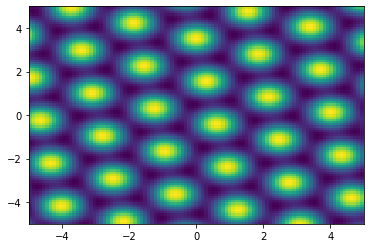

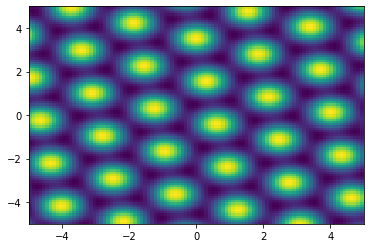

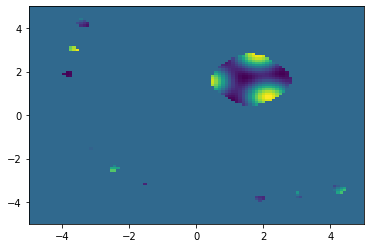

In [10]:
G_encoders, G_sorts = sample_grid_encoders(ssp_space, 10)

ssp_space.similarity_plot(G_encoders[9,:])
ssp_space.similarity_plot(region_mask_ssp(G_encoders[9,:].reshape(1,-1)))
similarity_plot_v2(ssp_space,G_encoders[9,:])

In [11]:
d = ssp_space.ssp_dim
n_neurons = 2000
G_encoders, G_sorts = sample_grid_encoders(ssp_space, n_neurons)
n_neurons = G_encoders.shape[0]
print(n_neurons)

2000


In [12]:
removerots = np.mod(G_sorts,n_rotates)
removerots[removerots==0] = n_rotates
removerots[G_sorts==0] = 0

In [157]:
removerots[:15]< break_idx

array([ True,  True,  True,  True, False, False,  True,  True,  True,
       False, False,  True,  True,  True, False])

In [158]:
r1_neurons= np.where(removerots < break_idx)[0]
r2_neurons = np.where(removerots >= break_idx)[0]

model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons, dimensions=d, radius = 1, 
                         encoders = G_encoders)
        
    in_node = nengo.Node(lambda t: ssp_space.encode(np.atleast_2d(path[int(t/dt)-1,:])).reshape(-1))
    nengo.Connection(in_node, ens, synapse=None)
    
    region_mem = nengo.networks.AssociativeMemory(S_regions, output_vectors=np.eye(2),
                                                  n_neurons=50, threshold=0.3)
    region_select = nengo.networks.Thalamus(2)
    nengo.Connection(region_mem.output, region_select.input)
    #region_mem.add_wta_network(inhibit_scale=1.01)
    
    nengo.Connection(in_node, region_mem.input, synapse=None)
    
    nengo.Connection(region_select.output[1],
                     ens.neurons[r1_neurons], transform=[[-10]] * len(r1_neurons))
    nengo.Connection(region_select.output[0],
                     ens.neurons[r2_neurons], transform=[[-10]] * len(r2_neurons))                                              
    
    ens_p = nengo.Probe(ens, synapse=0.1)
    region_mem_p = nengo.Probe(region_select.output, synapse=0.1)
    ens_n_p = nengo.Probe(ens.neurons, synapse=None)
    
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

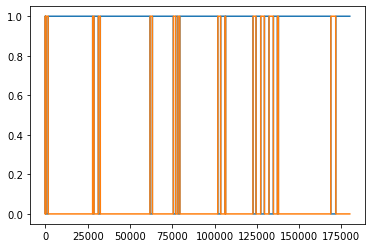

In [17]:
plt.figure()
plt.plot(sim.data[region_mem_p])

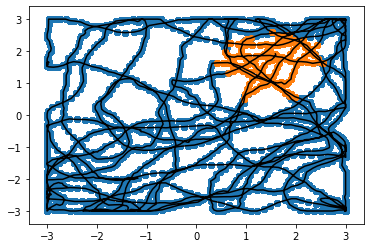

In [19]:
mem_reg_guess = np.argmax(sim.data[region_mem_p],axis=1)
sim_path = np.repeat(path, int(dt/sim.dt),axis=0)#[:int(50/sim.dt),:]
plt.figure()
plt.plot(path[:,0],path[:,1],'-k')
plt.scatter(sim_path[mem_reg_guess==0,0],sim_path[mem_reg_guess==0,1])
plt.scatter(sim_path[mem_reg_guess==1,0],sim_path[mem_reg_guess==1,1])

In [25]:
r1_pt = np.argmin(np.sum((path - np.array([-2,-2]))**2, axis=1))
r2_pt = np.argmin(np.sum((path - np.array([2,2]))**2, axis=1))

/home/ns2dumon/Documents/GitHub/ssp-bayesopt/ssp_bayes_opt/sspspace.py:348: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(X,Y,sims.reshape(X.shape),**kwargs)


NameError: name 'ens_p' is not defined

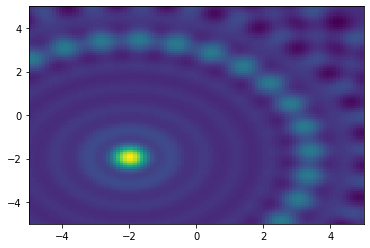

In [21]:
ssp_space.similarity_plot(ssp_space.encode(np.atleast_2d(path[r1_pt,:])))
ssp_space.similarity_plot(sim.data[ens_p][int(dt/sim.dt)*r1_pt,:])

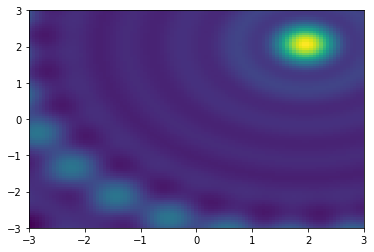

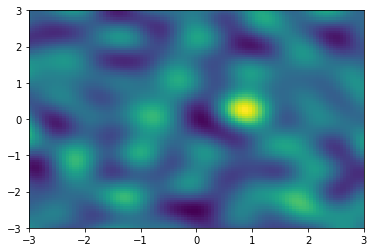

In [163]:
ssp_space.similarity_plot(ssp_space.encode(np.atleast_2d(path[r2_pt,:])))
ssp_space.similarity_plot(sim.data[ens_p][int(dt/sim.dt)*r2_pt,:])

In [262]:
r1_neurons= np.where(removerots < break_idx)[0]
r2_neurons = np.where(removerots >= break_idx)[0]

model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons, dimensions=d, radius = 1, 
                         encoders = G_encoders)
        
    in_node = nengo.Node(lambda t: region_mask_ssp(ssp_space.encode(np.atleast_2d(path[int(t/dt)-1,:]))).reshape(-1))
    nengo.Connection(in_node, ens, synapse=None)
    
    ens_p = nengo.Probe(ens, synapse=0.1)
    
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

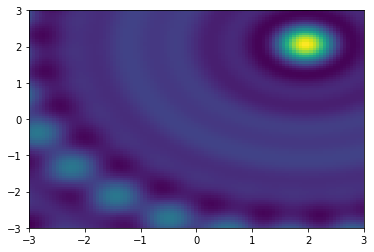

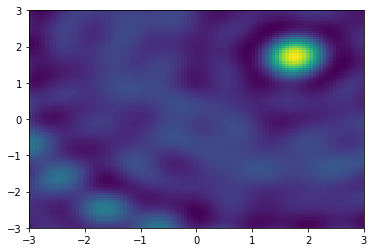

In [264]:
ssp_space.similarity_plot(region_mask_ssp(ssp_space.encode(np.atleast_2d(path[r2_pt,:]))))
ssp_space.similarity_plot(sim.data[ens_p][int(dt/sim.dt)*r2_pt,:])

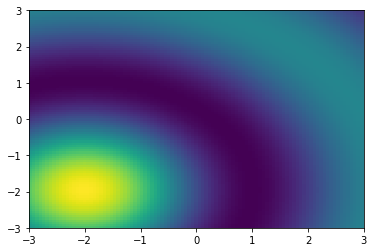

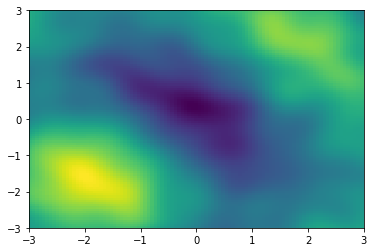

In [265]:
ssp_space.similarity_plot(region_mask_ssp(ssp_space.encode(np.atleast_2d(path[r1_pt,:]))))
ssp_space.similarity_plot(sim.data[ens_p][int(dt/sim.dt)*r1_pt,:])

In [283]:
domain_dim=2
phases_hex = np.hstack([np.sqrt(1+ 1/domain_dim)*np.identity(domain_dim) - 
                        (domain_dim**(-3/2))*(np.sqrt(domain_dim+1) + 1),
                         (domain_dim**(-1/2))*np.ones((domain_dim,1))]).T


scales = np.linspace(1,3,5)
phases_scaled = np.vstack([phases_hex*i for i in scales])


angles = np.linspace(0,2*np.pi/3,4,endpoint=False)
R_mats = np.stack([np.stack([np.cos(angles), -np.sin(angles)],axis=1),
                np.stack([np.sin(angles), np.cos(angles)], axis=1)], axis=1)
phases_scaled_rotated = (R_mats @ phases_scaled.T).transpose(0,2,1).reshape(-1,domain_dim)



In [284]:
phases_hex

array([[ 0.25881905, -0.96592583],
       [-0.96592583,  0.25881905],
       [ 0.70710678,  0.70710678]])

In [285]:
phases_scaled

array([[ 0.25881905, -0.96592583],
       [-0.96592583,  0.25881905],
       [ 0.70710678,  0.70710678],
       [ 0.38822857, -1.44888874],
       [-1.44888874,  0.38822857],
       [ 1.06066017,  1.06066017],
       [ 0.51763809, -1.93185165],
       [-1.93185165,  0.51763809],
       [ 1.41421356,  1.41421356],
       [ 0.64704761, -2.41481457],
       [-2.41481457,  0.64704761],
       [ 1.76776695,  1.76776695],
       [ 0.77645714, -2.89777748],
       [-2.89777748,  0.77645714],
       [ 2.12132034,  2.12132034]])

In [286]:
phases_scaled_rotated

array([[ 0.25881905, -0.96592583],
       [-0.96592583,  0.25881905],
       [ 0.70710678,  0.70710678],
       [ 0.38822857, -1.44888874],
       [-1.44888874,  0.38822857],
       [ 1.06066017,  1.06066017],
       [ 0.51763809, -1.93185165],
       [-1.93185165,  0.51763809],
       [ 1.41421356,  1.41421356],
       [ 0.64704761, -2.41481457],
       [-2.41481457,  0.64704761],
       [ 1.76776695,  1.76776695],
       [ 0.77645714, -2.89777748],
       [-2.89777748,  0.77645714],
       [ 2.12132034,  2.12132034],
       [ 0.70710678, -0.70710678],
       [-0.96592583, -0.25881905],
       [ 0.25881905,  0.96592583],
       [ 1.06066017, -1.06066017],
       [-1.44888874, -0.38822857],
       [ 0.38822857,  1.44888874],
       [ 1.41421356, -1.41421356],
       [-1.93185165, -0.51763809],
       [ 0.51763809,  1.93185165],
       [ 1.76776695, -1.76776695],
       [-2.41481457, -0.64704761],
       [ 0.64704761,  2.41481457],
       [ 2.12132034, -2.12132034],
       [-2.89777748,

\begin{align}
K &= \text{simplex} \in \mathbb{R}^{3\times 2}\\
B &= \begin{bmatrix}
s_1 R_1 K \\ s_2 R_1 K \\ \vdots \\ s_{n_s} R_1 K \\ s_1 R_2 K \\ s_2 R_2 K \\ \vdots \\ s_{n_s} R_{n_r} K
\end{bmatrix} \in \mathbb{R}^{3n_s n_r\times 2}\\
A' &= \begin{bmatrix}
B \\ 1\\ -\text{flip}(B)
\end{bmatrix} \in \mathbb{R}^{(6n_s n_r+1)\times 2} \\
A &= \text{fftshift}(A') = HA' \in \mathbb{R}^{(6n_s n_r+1)\times 2}\\
S &= \mathcal{F}^{-1} \{ e^{iA\mathbf{x}}\} \in \mathbb{R}^{d}\\
e^{iA\mathbf{x}} = \bar{S} &= WS = W_r S + iW_iS= \bar{S}_r + \bar{S}_i 
\end{align}
And 
\begin{align}
M_1 &= \begin{bmatrix}
I_{3n_s n_r} \\
\mathbf{0}_{1 \times 3n_s n_r} \\
\text{flip}(I_{3n_s n_r})
\end{bmatrix} \in \mathbb{R}^{d-1 \times 3n_s n_r} \\
&= \begin{bmatrix}
1 & &   \\
 & \ddots &  \\
 && 1 \\
 0 & \dots & 0 \\
 & &  1 \\
 & \cdot^{\cdot^{\cdot}} &  \\
1 &&  \\
\end{bmatrix} \\
M_2 &= \begin{bmatrix}
I_{3n_s n_r} \\
\mathbf{0}_{1 \times 3n_s n_r} \\
-\text{flip}(I_{3n_s n_r})
\end{bmatrix} \\
M &= \begin{bmatrix}
M_1 & \mathbf{0} & 0\\
& & 1 \\
\mathbf{0} & M_2 & 0
\end{bmatrix} \in \mathbb{R}^{2(d-1) \times d} \\
Q &= \begin{bmatrix}
W_r H^{-1}  & -W_i H^{-1} 
\end{bmatrix} \in \mathbb{R}^{d \times 2d} \\
S^T Q = \begin{bmatrix}
S^TW_r H^{-1}  & -S^TW_i H^{-1} 
\end{bmatrix} = \begin{bmatrix}
\bar{S}_r^T H^{-1}  & -\bar{S}_i^TH^{-1} 
\end{bmatrix}
\end{align}

In [2]:
def _get_to_SSP_mat(D):
#     W = np.fft.ifft(np.eye(D))
#     W1 = W.real @ np.fft.ifftshift(np.eye(D),axes=0)
#     W2 = W.imag @ np.fft.ifftshift(np.eye(D),axes=0)
#     Wnew2 = np.zeros((D,2*D))
#     Wnew2[:,0::2] = W1
#     Wnew2[:,1::2] = -W2
#     shiftmat = np.zeros((2*D,D+1))
#     shiftmat[:D,:-1] = np.eye(D)
#     shiftmat[D+1:,1:-1] = -np.flip(np.eye(D-1),axis=0)
#     tr = Wnew2 @ shiftmat
    tr = np.linalg.pinv(_get_from_SSP_mat(D))
    return tr

def _get_from_SSP_mat(D):
    W = np.fft.fft(np.eye(D))
    W1 = np.fft.fftshift(np.eye(D),axes=0) @ W.real 
    W2 = np.fft.fftshift(np.eye(D),axes=0) @ W.imag 
    Wnew = np.zeros((2*D,D))
    Wnew[0::2,:] = W1
    Wnew[1::2,:] = W2
    shiftmat = np.zeros((D,2*D))
    shiftmat[:D,:D] = np.eye(D)
    #shiftmat[(D-1):(2*D-2),(D+1):] = np.eye(D-1)
    return shiftmat @ Wnew



In [44]:
d = ssp_space.ssp_dim
to_SSP = _get_to_SSP_mat(d)
from_SSP = _get_from_SSP_mat(d)

dim_per_ens = ssp_space.grid_basis_dim*2

n_neurons = 400
model = nengo.Network()
with model:
    in_node = nengo.Node(lambda t: region_mask_ssp(ssp_space.encode(np.atleast_2d(path[int(t/dt)-1,:]))).reshape(-1))
    
    ens = nengo.networks.EnsembleArray(n_neurons, ssp_space.num_grids + 1, dim_per_ens,
                                      radius =np.sqrt(3))
    nengo.Connection(in_node, ens.input[:-dim_per_ens+1], transform=from_SSP, synapse=None)
    
    ssp = nengo.Node(size_in=d)
    nengo.Connection(ens.output[:-dim_per_ens+1], ssp, transform=to_SSP) 
    
    ssp_p = nengo.Probe(ssp, synapse=0.1)
    fssp_p = nengo.Probe(ens.output, synapse=0.1)
    
    fssp1_p = nengo.Probe(ens.ea_ensembles[13], synapse=0.1)
    fssp2_p = nengo.Probe(ens.ea_ensembles[1], synapse=0.1)
        
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [46]:
from nengo.utils.ensemble import response_curves, tuning_curves

xs = np.linspace(-5,5,100)
ys = np.linspace(-5,5,100)
X,Y = np.meshgrid(xs,ys)
inputs = ssp_space.encode(np.vstack([X.reshape(-1),Y.reshape(-1)]).T)
subinputs = (to_SSP @ inputs.T).T

with nengo.Simulator(model) as sim:
    _, activities0 = tuning_curves(ens.ea_ensembles[0], sim, inputs=subinputs[:,0:dim_per_ens])
    _, activities1 = tuning_curves(ens.ea_ensembles[1], sim, inputs=subinputs[:,dim_per_ens:2*dim_per_ens])
    _, activities2 = tuning_curves(ens.ea_ensembles[2], sim, inputs=subinputs[:,2*dim_per_ens:3*dim_per_ens])
    _, activities3 = tuning_curves(ens.ea_ensembles[3], sim, inputs=subinputs[:,3*dim_per_ens:4*dim_per_ens])
    _, activities4 = tuning_curves(ens.ea_ensembles[4], sim, inputs=subinputs[:,4*dim_per_ens:5*dim_per_ens])
    _, activities5 = tuning_curves(ens.ea_ensembles[5], sim, inputs=subinputs[:,5*dim_per_ens:6*dim_per_ens])

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [47]:
np.where(np.sum(activities0,axis=0)>0)


(array([  0,   2,   3,   4,   9,  10,  11,  13,  14,  16,  18,  19,  21,
         23,  26,  27,  28,  29,  30,  33,  34,  35,  36,  40,  41,  42,
         48,  49,  52,  53,  54,  55,  58,  59,  61,  64,  66,  70,  72,
         73,  74,  76,  77,  78,  81,  84,  87,  88,  90,  93,  98, 100,
        103, 105, 106, 107, 108, 109, 110, 111, 112, 114, 116, 117, 118,
        122, 123, 125, 126, 128, 129, 134, 135, 137, 140, 142, 143, 145,
        147, 150, 152, 153, 155, 156, 159, 160, 162, 164, 166, 167, 168,
        169, 170, 173, 174, 177, 181, 182, 184, 185, 186, 187, 188, 189,
        193, 194, 195, 196, 197, 198, 199, 200, 201, 205, 207, 208, 210,
        212, 213, 214, 216, 217, 219, 220, 223, 225, 226, 228, 230, 231,
        232, 233, 234, 239, 240, 243, 248, 249, 255, 256, 258, 259, 260,
        263, 264, 267, 269, 271, 273, 274, 277, 278, 279, 280, 284, 287,
        288, 289, 290, 293, 295, 296, 300, 302, 304, 305, 306, 307, 308,
        310, 311, 312, 314, 315, 319, 320, 323, 325

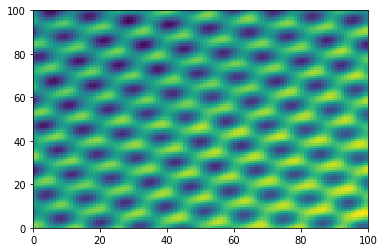

In [49]:
plt.pcolormesh(activities0[:,2].reshape(X.shape))

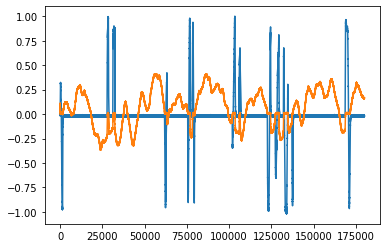

In [223]:
plt.plot(sim.data[fssp_p][:,13]);
plt.plot(sim.data[fssp_p][:,1]);

In [30]:
ssp1 = sim.data[ssp_p]
fssp1 = sim.data[fssp_p]
fssp1_r1 = sim.data[fssp1_p]
fssp1_r2 = sim.data[fssp2_p]


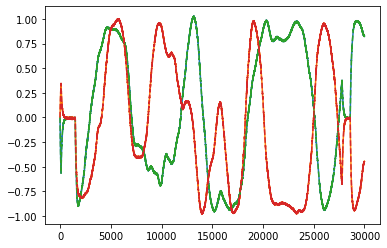

In [31]:
idx = 3
plt.plot(sim.data[fssp1_p][:30000,idx])
plt.plot(sim.data[fssp2_p][:30000,idx])
plt.plot(fssp1_r1[:30000,idx],'--')
plt.plot(fssp1_r2[:30000,idx],'--')


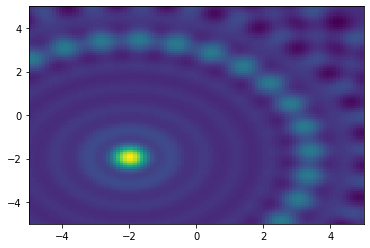

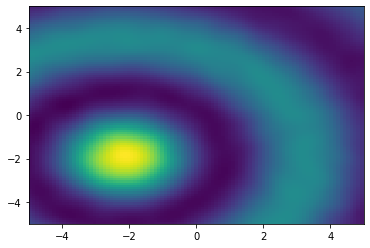

In [224]:
ssp_space.similarity_plot(ssp_space.encode(np.atleast_2d(path[r1_pt,:])))
ssp_space.similarity_plot(sim.data[ssp_p][int(dt/sim.dt)*r1_pt,:])

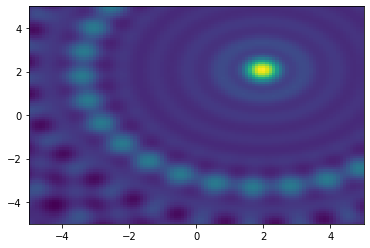

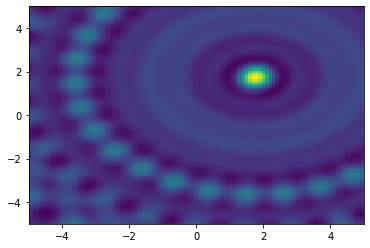

In [225]:
ssp_space.similarity_plot(ssp_space.encode(np.atleast_2d(path[r2_pt,:])))
ssp_space.similarity_plot(sim.data[ssp_p][int(dt/sim.dt)*r2_pt,:])

In [43]:
r1_subens

array([ 4,  5, 10, 11, 16, 17, 22, 23, 28, 29])

In [42]:
r2_subens

array([ 0,  1,  2,  3,  6,  7,  8,  9, 12, 13, 14, 15, 18, 19, 20, 21, 24,
       25, 26, 27])

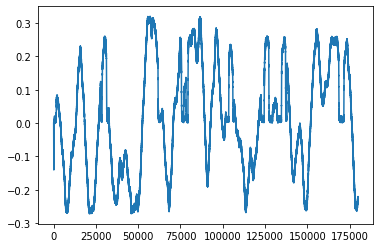

In [117]:
plt.plot(sim.data[fssp_p][:,109]);


In [120]:
scale_mask[:,1]

array([1., 1., 1., 1., 0., 0.])

In [234]:
gc_mask = np.tile(scale_mask,(n_rotates,1))
np.where(gc_mask[:,0])[0]

array([ 4,  5, 10, 11, 16, 17, 22, 23, 28, 29])

In [271]:
20**2

400

In [15]:
break_idx=4
scale_mask = np.ones((n_scales,2))
scale_mask[:break_idx,0] = 0
scale_mask[break_idx:,1] = 0

gc_mask = np.tile(scale_mask,(n_rotates,1))

r1_subens =  np.where(gc_mask[:,1])[0]
r2_subens = np.where(gc_mask[:,0])[0]

to_SSP = _get_to_SSP_mat(d)
from_SSP = _get_from_SSP_mat(d)
dim_per_ens = ssp_space.grid_basis_dim*2


xs = np.linspace(-5,5,20)
ys = np.linspace(-5,5,20)
X,Y = np.meshgrid(xs,ys)
sample_ssps = ssp_space.encode(np.vstack([X.reshape(-1),Y.reshape(-1)]).T)
subsample_ssps = (to_SSP @ sample_ssps.T).T


n_neurons = 400
model = nengo.Network()
with model:
    in_node = nengo.Node(lambda t: ssp_space.encode(np.atleast_2d(path[int(t/dt)-1,:])).reshape(-1))
    
    ens = nengo.networks.EnsembleArray(n_neurons, ssp_space.num_grids + 1, dim_per_ens,
                                      radius =np.sqrt(3))
    for i in range(ssp_space.num_grids):
        ens.ea_ensembles[i].encoders = subsample_ssps[:,i*dim_per_ens:(i+1)*dim_per_ens]
    nengo.Connection(in_node, ens.input[:-dim_per_ens+1], transform=from_SSP, synapse=None)
    
    ssp = nengo.Node(size_in=d)
    nengo.Connection(ens.output[:-dim_per_ens+1], ssp, transform=to_SSP) 
    
#     region_mem = nengo.networks.AssociativeMemory(S_regions, output_vectors=np.eye(2),
#                                                   n_neurons=50, threshold=0.3)
    
#     def one_hot(t,x):
#         r = np.zeros(len(x))
#         r[np.argmax(x)]=1
#         return r
    
#     region_select = nengo.Node(one_hot, size_in=2)
#     nengo.Connection(region_mem.output, region_select, synapse=0.1)
    
#     nengo.Connection(in_node, region_mem.input, synapse=None)

    def perfect_select(t):
        dist = np.sqrt(np.sum((path[int(t/dt)-1,:] - np.array([1.5,1.5]))**2))
        selected = np.zeros(2)
        if dist > 1:
            selected[0] = 1
        else:
            selected[1] = 1
        return selected

    region_select = nengo.Node(perfect_select)
    
    for i in r1_subens:
        nengo.Connection(region_select[1],
                     ens.ea_ensembles[i].neurons, transform=[[-10]] * n_neurons)
    for i in r2_subens:   
        nengo.Connection(region_select[0],
                     ens.ea_ensembles[i].neurons, transform=[[-10]] * n_neurons) 
    
    ssp_p = nengo.Probe(ssp, synapse=0.1)
    fssp_p = nengo.Probe(ens.output, synapse=0.1)
    
    fssp1_p = nengo.Probe(ens.ea_ensembles[r1_subens[0]], synapse=0.1)
    fssp2_p = nengo.Probe(ens.ea_ensembles[r2_subens[0]], synapse=0.1)
    
    region_mem_p = nengo.Probe(region_select, synapse=None)
    
sim = nengo.Simulator(model)
sim.run(T)

/home/ns2dumon/anaconda3/lib/python3.7/site-packages/nengo/cache.py:613: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [28]:
inputs = ssp_space.encode(np.vstack([X.reshape(-1),Y.reshape(-1)]).T)
inputs.shape

(400, 181)

In [29]:
(to_SSP @ inputs.T).shape

(181, 400)

In [30]:
from nengo.utils.ensemble import response_curves, tuning_curves

xs = np.linspace(-5,5,100)
ys = np.linspace(-5,5,100)
X,Y = np.meshgrid(xs,ys)
inputs = ssp_space.encode(np.vstack([X.reshape(-1),Y.reshape(-1)]).T)
subinputs = (to_SSP @ inputs.T).T

with nengo.Simulator(model) as sim:
    _, activities0 = tuning_curves(ens.ea_ensembles[0], sim, inputs=subinputs[:,0:dim_per_ens])
    _, activities1 = tuning_curves(ens.ea_ensembles[1], sim, inputs=subinputs[:,dim_per_ens:2*dim_per_ens])
    _, activities2 = tuning_curves(ens.ea_ensembles[2], sim, inputs=subinputs[:,2*dim_per_ens:3*dim_per_ens])
    _, activities3 = tuning_curves(ens.ea_ensembles[3], sim, inputs=subinputs[:,3*dim_per_ens:4*dim_per_ens])
    _, activities4 = tuning_curves(ens.ea_ensembles[4], sim, inputs=subinputs[:,4*dim_per_ens:5*dim_per_ens])
    _, activities5 = tuning_curves(ens.ea_ensembles[5], sim, inputs=subinputs[:,5*dim_per_ens:6*dim_per_ens])

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

(array([  0,   2,   4,   6,   8,  10,  11,  12,  13,  14,  16,  18,  20,
         21,  22,  24,  30,  32,  33,  34,  35,  39,  41,  42,  43,  45,
         47,  49,  53,  54,  55,  56,  57,  58,  62,  63,  64,  65,  66,
         72,  78,  81,  82,  85,  88,  90,  91,  92,  93,  95,  98,  99,
        100, 101, 102, 105, 106, 107, 108, 110, 111, 114, 117, 121, 122,
        123, 125, 128, 129, 130, 134, 136, 137, 139, 141, 146, 149, 150,
        151, 152, 157, 158, 166, 172, 173, 174, 177, 178, 180, 182, 184,
        185, 186, 187, 188, 191, 192, 193, 194, 195, 196, 198, 199, 201,
        203, 205, 206, 207, 209, 210, 211, 212, 214, 220, 221, 224, 226,
        227, 229, 230, 234, 236, 237, 238, 240, 241, 243, 246, 247, 248,
        250, 255, 256, 257, 258, 261, 262, 263, 266, 268, 270, 273, 275,
        278, 279, 282, 287, 289, 294, 301, 302, 303, 304, 311, 314, 315,
        316, 318, 319, 320, 321, 322, 324, 326, 327, 329, 332, 333, 335,
        340, 341, 342, 345, 346, 348, 349, 350, 352

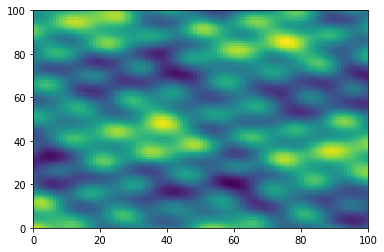

In [39]:
np.where(np.sum(activities4,axis=0)>0)
plt.pcolormesh(activities4[:,0].reshape(X.shape))

In [73]:
np.minimum((np.sum(ssp1**2,axis=1)*np.sum(sim.data[ssp_p]**2,axis=1)),1e-6)

array([0.00000000e+00, 0.00000000e+00, 1.17089058e-10, ...,
       1.00000000e-06, 1.00000000e-06, 1.00000000e-06])

<ipython-input-78-9bcfc8ec96a4>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(np.sum(ssp1*sim.data[ssp_p],axis=1)/(np.sum(ssp1**2,axis=1)*np.sum(sim.data[ssp_p]**2,axis=1)))


(0.0, 2.0)

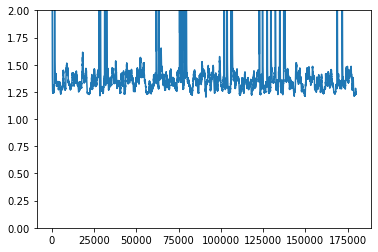

In [78]:
plt.figure()
plt.plot(np.sum(ssp1*sim.data[ssp_p],axis=1)/(np.sum(ssp1**2,axis=1)*np.sum(sim.data[ssp_p]**2,axis=1)))
plt.ylim([0,2])

In [100]:
r1_subens

array([ 0,  1,  2,  3,  6,  7,  8, 11, 12, 13, 16, 17, 18, 21, 22, 23, 26,
       27, 28])

In [16]:
idx=6*6
plt.figure()
plt.plot(fssp1[:10000,idx])
plt.plot(sim.data[fssp_p][:10000,idx])

NameError: name 'fssp1' is not defined

<Figure size 432x288 with 0 Axes>

In [43]:
fssp1_r1 = sim.data[fssp1_p]
fssp2_r2 = sim.data[fssp2_p]

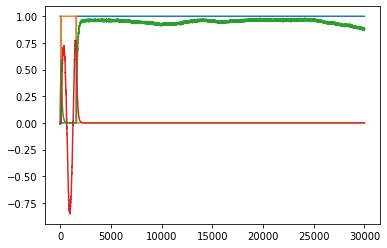

In [17]:
plt.plot(sim.data[region_mem_p][:30000])
plt.plot(sim.data[fssp1_p][:30000,4])
plt.plot(sim.data[fssp2_p][:30000,4])

In [254]:
sim.data[fssp2_p][int(dt/sim.dt)*r1_pt,:]

array([-4.47203600e-27, -1.02466183e-27, -3.48751963e-27, -6.60633703e-27,
       -5.40510167e-27,  7.15788837e-27])

In [258]:
sim.data[fssp_p][100,-6:]

array([ 0.58568538, -0.03214494,  0.01233324,  0.01813477, -0.01536344,
        0.01959191])

In [20]:
ssp_path = ssp_space.encode(sim_path)
sims = np.sum(ssp_path * sim.data[ssp_p], axis=1)

In [21]:
sims2 = np.sum(region_mask_ssp(ssp_path) * sim.data[ssp_p], axis=1)


/home/ns2dumon/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


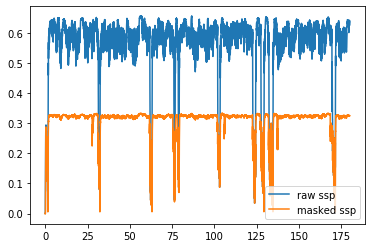

In [23]:
plt.figure()
plt.plot(sim.trange(), sims)
plt.plot(sim.trange(), sims2)
plt.legend(['raw ssp','masked ssp'])

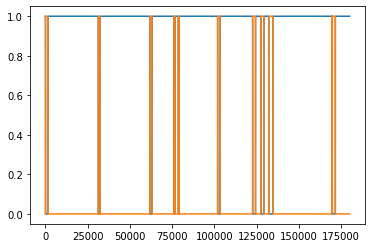

In [24]:
plt.figure()
plt.plot(sim.data[region_mem_p])

In [25]:
r1_pt = np.argmin(np.sum((path - np.array([-2,-2]))**2, axis=1))
r2_pt = np.argmin(np.sum((path - np.array([2,2]))**2, axis=1))

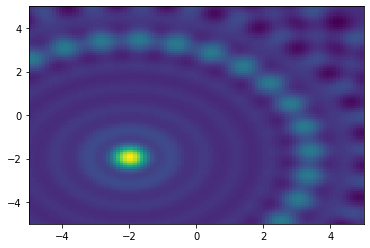

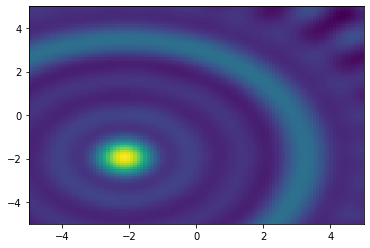

In [26]:
ssp_space.similarity_plot(ssp_space.encode(np.atleast_2d(path[r1_pt,:])))
ssp_space.similarity_plot(sim.data[ssp_p][int(dt/sim.dt)*r1_pt,:])

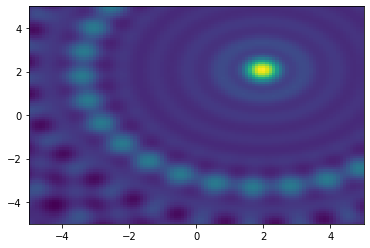

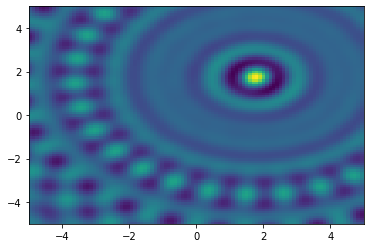

In [27]:
ssp_space.similarity_plot(ssp_space.encode(np.atleast_2d(path[r2_pt,:])))
ssp_space.similarity_plot(sim.data[ssp_p][int(dt/sim.dt)*r2_pt,:])

/home/ns2dumon/Documents/GitHub/ssp-bayesopt/ssp_bayes_opt/sspspace.py:348: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(X,Y,sims.reshape(X.shape),**kwargs)


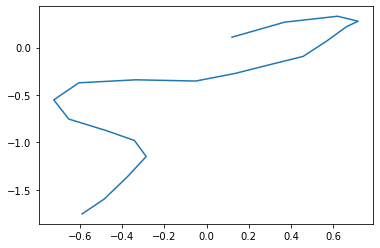

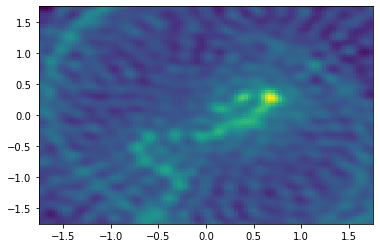

In [279]:
import seaborn as sns
traj_len = 20

process1 = nengo.processes.FilteredNoise(synapse=nengo.synapses.Alpha(.015), seed=3)
process2 = nengo.processes.FilteredNoise(synapse=nengo.synapses.Alpha(.015), seed=1)
y = np.hstack([process1.run_steps(traj_len),process2.run_steps(traj_len)])
plt.figure()
plt.plot(y[:,0],y[:,1])

bounds = np.max(np.abs(y))*np.array([[-1,1],[-1,1]])
ssp_space = ssp_bayes_opt.sspspace.HexagonalSSPSpace(2,
                                    ssp_dim=1000,
                                    scale_min=0.05,
                                    scale_max=3,
                                    domain_bounds=bounds, 
                                    length_scale=0.1,
                                      )

tssp_space = ssp_bayes_opt.sspspace.RandomSSPSpace(1, ssp_dim=ssp_space.ssp_dim)
Ts = tssp_space.encode(np.atleast_2d(np.linspace(0,0.5,traj_len)).T)




ssp_path = ssp_space.encode(y)
traj_path = np.sum([ssp_space.bind(ssp_path[i,:], Ts[i]) for i in range(traj_len)],axis=0)
fi
ssp_space.similarity_plot(traj_path)

In [263]:
y

array([[ 0.1202429 ,  0.10919875],
       [ 0.36933678,  0.26763792],
       [ 0.62035734,  0.33034112],
       [ 0.71839297,  0.27774809],
       [ 0.66272555,  0.21974696],
       [ 0.56956413,  0.06899701],
       [ 0.45728796, -0.09392286],
       [ 0.30965328, -0.17509033],
       [ 0.13589511, -0.27289839],
       [-0.05163793, -0.35361113],
       [-0.33456031, -0.34052132],
       [-0.60579153, -0.37212561],
       [-0.72451377, -0.55238694],
       [-0.65380237, -0.75440051],
       [-0.47590253, -0.87653661],
       [-0.34221751, -0.98081694],
       [-0.2864814 , -1.1503197 ],
       [-0.37554378, -1.3639824 ],
       [-0.48533029, -1.59891281],
       [-0.59024456, -1.75597218],
       [-0.83007689, -1.92263595],
       [-1.12654732, -2.05431722],
       [-1.29464042, -2.02679578],
       [-1.32488754, -1.90252299],
       [-1.39945187, -1.69297596],
       [-1.572653  , -1.49058031],
       [-1.7215081 , -1.35947699],
       [-1.81520682, -1.30989496],
       [-1.95166702,

In [267]:
ssp_space.decode(ssp_path[0,:].reshape(1,-1))

array([0.1474569 , 0.08847414])

In [262]:
ssp_space.decode(ssp_space.bind(traj_path, ssp_space.invert(Ts[0])))

array([-1.38609485, -1.50406037])

In [247]:
xs = np.linspace(ssp_space.domain_bounds[0,0],ssp_space.domain_bounds[0,1], 100)
ys = np.linspace(ssp_space.domain_bounds[1,0],ssp_space.domain_bounds[1,1], 100)
X,Y = np.meshgrid(xs,ys)
sspXY = ssp_space.encode(np.vstack([X.reshape(-1),Y.reshape(-1)]).T).T 
sspXY.shape

(865, 10000)

In [270]:
ssp_thru_traj= np.array([ssp_space.bind(traj_path, ssp_space.invert(Ts[i])) for i in range(traj_len)]).reshape(-1,ssp_space.ssp_dim)
ssp_thru_traj.shape

(60, 865)

In [271]:
sims = ssp_thru_traj @ sspXY
sims.shape

(60, 10000)

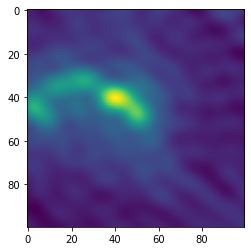

In [258]:
plt.imshow(sims[50,:].reshape((len(xs), len(ys))),animated=True)

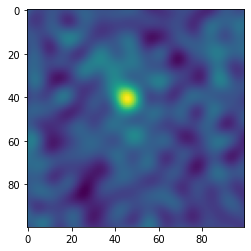

In [276]:


from matplotlib import animation

ssp_frames = [] # for storing the generated images
fig = plt.figure()
for i in range(traj_len):
    ssp_frames.append([plt.imshow(sims[i,:].reshape((len(xs), len(ys))),animated=True)])

ani = animation.ArtistAnimation(fig, ssp_frames, interval=10, blit=True,
                                repeat_delay=1000)
ani.save('ssp-traj.mp4')
plt.show()

